In [1]:
# Import libraries and setup matplotlib defaults
from matplotlib import pyplot as pl
import pandas as pd
import numpy as np
pl.style.use('bmh')
clist = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3', '#ff7f00',
         '#ffff33', '#a65628', '#f781bf', '#999999']
prop_cycle = pl.cycler(color=clist)
pl.rcParams.update({
    'axes.prop_cycle': prop_cycle,
    'lines.linewidth': 2,
    'font.size': 20,
    'figure.figsize': [12, 8],
    'figure.subplot.left': 0.125,
    'figure.subplot.right': 0.95,
    'figure.subplot.bottom': 0.15})

In [2]:
import sys
sys.path.append('../')
from data_utils import *

md = load_membership_data()
td_raw = load_temple_data()

# deal with cases where no groundbreaking is listed, because groundbreaking date is used later
td = td_raw.copy()
missing_gr = td['Groundbreaking date'].isna() & ~td['Dedication date'].isna()
td.loc[missing_gr, 'Groundbreaking date'] = td[missing_gr]['Dedication date'] - np.timedelta64(3, 'Y')

# for this analysis, exclude temple temples that won't be built
exclude = ['Efforts halted in 1830s', 'Efforts suspended in 2006', 'Historic site', 'Destroyed']
td = td[~td['Status'].isin(exclude)]

In [3]:
most_common_size_count = td.value_counts('area').iloc[0]

# Area categories
td['area_cat'] = ''
td.loc[td['area']>0, 'area_cat'] = '0-12000'
td.loc[td['area']>12000, 'area_cat'] = '12000-20000'
td.loc[td['area']>20000, 'area_cat'] = '20000-30000'
td.loc[td['area']>30000, 'area_cat'] = '30000-40000'
td.loc[td['area']>40000, 'area_cat'] = '40000-50000'
td.loc[td['area']>50000, 'area_cat'] = '50000-70000'
td.loc[td['area']>70000, 'area_cat'] = '70000-100000'
td.loc[td['area']>100000, 'area_cat'] = '100000+'

# Dedication decade
td['ded_dec'] = 'future'
td.loc[td['Dedication date'].dt.year>0, 'ded_dec'] = 'earlier'
td.loc[td['Dedication date'].dt.year>=1980, 'ded_dec'] = '1980s'
td.loc[td['Dedication date'].dt.year>=1990, 'ded_dec'] = '1990s'
td.loc[td['Dedication date'].dt.year>=2000, 'ded_dec'] = '2000s'
td.loc[td['Dedication date'].dt.year>=2010, 'ded_dec'] = '2010s'
td.loc[td['Dedication date'].dt.year>=2020, 'ded_dec'] = '2020s'

# region categories
td['reg_cat'] = 'non-US'
td.loc[td['Country']=='United States', 'reg_cat'] = 'other US'
td.loc[td['Region'].isin(['Utah', 'Idaho', 'Arizona']), 'reg_cat'] = 'UT/ID/AZ'

#td['area_cat'].value_counts().sort_index()
#td.value_counts('ded_dec').sort_index()
#td['reg2'].value_counts()

In [4]:
# For projecting future costs, estimate sizes of announced temples. Small, medium, and large
# temples are assigned to be 10,000, 20,000, and 30,000 square feet. Most of the temples are
# presumed to be small, including all of those in Europe and Asia. A few are presumed medium
# based on being near large population centers in countries with large church membership.
small_temple_list = [
    'Antananarivo Madagascar Temple',
    'Abidjan Ivory Coast Temple',
    'Alabang Philippines Temple',
    'Nairobi Kenya Temple',
    'Cagayan de Oro Philippines Temple',
    'Dubai United Arab Emirates Temple',
    'Brussels Belgium Temple',
    'Retalhuleu Guatemala Temple',
    'Iquitos Peru Temple',
    'Iloilo Philippines Temple',
    'Jakarta Indonesia Temple',
    'Fairbanks Alaska Temple',
    'Colorado Springs Colorado Temple',
    'Culiacán Mexico Temple',
    'Cape Coast Ghana Temple',
    'Calabar Nigeria Temple',
    'Luanda Angola Temple',
    'Mbuji-Mayi Democratic Republic of the Congo Temple',
    'Beira Mozambique Temple',
    'Monrovia Liberia Temple',
    'Kananga Democratic Republic of the Congo Temple',
    'Brazzaville Republic of the Congo Temple',
    'Birmingham England Temple',
    'Cusco Peru Temple',
    'Missoula Montana Temple',
    'Busan Korea Temple',
    'Naga Philippines Temple',
    "Savai'i Samoa Temple",
    'Piura Peru Temple',
    'Huancayo Peru Temple',
    'Santiago Philippines Temple',
    'Eket Nigeria Temple',
    'Chiclayo Peru Temple',
    'Buenos Aires City Center Argentina Temple',
    'Jacksonville Florida Temple',
    'Laoag Philippines Temple',
    'Osaka Japan Temple',
    'Vancouver Washington Temple',
    'Tulsa Oklahoma Temple',
    'Roanoke Virginia Temple',
    'Cancún Mexico Temple',
    'Tacoma Washington Temple',
    'Cuernavaca Mexico Temple',
    'Pachuca Mexico Temple',
    'Salta Argentina Temple',
    'Singapore Republic of Singapore Temple',
    'Tuguegarao City Philippines Temple',
    'Tacloban City Philippines Temple',
    'Toluca Mexico Temple',
    'Tula Mexico Temple',
    'Urdaneta Philippines Temple',
    'Ulaanbaatar Mongolia Temple',
    'Vienna Austria Temple']

medium_temple_list = [
    'Auckland New Zealand Temple',
    'Viña del Mar Chile Temple',
    'Hamburg Germany Temple',
    'Springfield Missouri Temple',
    'Winchester Virginia Temple',
    'Harrisburg Pennsylvania Temple',
    'Goiânia Brazil Temple',
    'João Pessoa Brazil Temple']

large_temple_list = [
    'Prosper Texas Temple']

even_larger_list = []

who_knows_if_it_will_get_built_list = [
    'Russia Temple',
    "Shanghai People's Republic of China Temple"]

# Check whether items need to be added or removed
combined_list = small_temple_list+medium_temple_list+large_temple_list+even_larger_list+ \
            who_knows_if_it_will_get_built_list
no_area = td['area'].isna()
in_lists = td['Name'].isin(combined_list)
to_add_to_lists = td[no_area & ~in_lists]['Name'].to_list()
to_remove_from_lists = td[in_lists & ~no_area]['Name'].to_list()

if len(to_add_to_lists):
    print('need to add to lists:')
    print(to_add_to_lists)

if len(to_remove_from_lists):
    print('need to remove from lists:')
    print(to_remove_from_lists)
    print(td[td['Name'].isin(to_remove_from_lists)][['Name', 'area']])


td.loc[td['Name'].isin(small_temple_list), 'area'] = 10000
td.loc[td['Name'].isin(medium_temple_list), 'area'] = 20000
td.loc[td['Name'].isin(large_temple_list), 'area'] = 30000
td.loc[td['Name'].isin(even_larger_list), 'area'] = 40000

td['area_estimated'] = 0
td.loc[td['Name'].isin(small_temple_list+medium_temple_list+large_temple_list), 'area_estimated'] = 1

# estimate site size for temples that don't have lots yet.
# based on previous averages, small:3 acres, medium: 6 acres, large: 10 acres
lot_dict = {10000:3, 20000:6, 30000:10, 40000:10}
site_idx = td['site'].isna() & ~td['area'].isna()

td[site_idx][['Name', 'area', 'Announcement date']]
td['site_estimated'] = 0
td.loc[site_idx, 'site_estimated'] = 1

td.loc[site_idx, 'site'] = td[site_idx]['area'].replace(lot_dict)

In [5]:
# Use temples completed since 2008 as a reference for estimating planning and construction time
# set minimum date for estimated grounbreaking and dedication so they aren't in the past
min_date = pd.to_datetime('2023-07-01')

ref_temples = td[(td['Announcement date'].dt.year>=2008) & (~td['Dedication date'].isna())]
est_times = ref_temples[['Announcement date', 'Groundbreaking date',
                         'Dedication date']].diff(axis=1).mean()

gr_est = td['Groundbreaking date'].isna()
td.loc[gr_est, 'Groundbreaking date'] = td[gr_est][
    'Announcement date'] + est_times['Groundbreaking date']
idx = gr_est & (td['Groundbreaking date'] < min_date)
td.loc[idx, 'Groundbreaking date'] = min_date

de_est = td['Dedication date'].isna()
td.loc[de_est, 'Dedication date'] = td[de_est][
    'Groundbreaking date'] + est_times['Dedication date']
idx = de_est & (td['Dedication date'] < min_date)
td.loc[idx, 'Dedication date'] = min_date

td['completion_estimated'] = 0
td.loc[de_est, 'completion_estimated'] = 1

In [6]:
# costs are per square foot and per acre
construction_cost = 1000
land_cost = 1000000

date_info = td[~td['Dedication date'].isna() & ~td['Groundbreaking date'].isna() &
               (td['Dedication date']>pd.to_datetime('1950-01-01'))][
    ['Groundbreaking date', 'Dedication date', 'area',
     'site', 'completion_estimated', 'site_estimated']]
date_info['land_purchase'] = date_info['Groundbreaking date'].dt.year - 1

date_info['years'] = date_info.apply(lambda x: range(x['Groundbreaking date'].year,
                                                     x['Dedication date'].year+1), axis=1)
date_info['area_amortized'] = date_info['area'] / date_info['years'].str.len()

years = date_info.explode('years')[['years', 'area_amortized', 'completion_estimated']]

yearly_total_ = years.groupby(['years', 'completion_estimated']).sum().reset_index().pivot(
    index='years', columns='completion_estimated').fillna(0)
yearly_total_.columns = ['area_amortized', 'area_amortized_est']

yearly_total = pd.Series(index=range(1950,2029), dtype='float64').to_frame('x').join(
    yearly_total_).drop(columns='x').fillna(0)

land_acres = date_info[['land_purchase', 'site', 'site_estimated']].groupby(
    ['land_purchase', 'site_estimated']).sum().reset_index().pivot(
    index='land_purchase', columns='site_estimated').fillna(0)
land_acres.columns = ['land', 'land_est']

yearly_total = yearly_total.join(land_acres).fillna(0)
yearly_total['land cost'] = yearly_total['land']*land_cost
yearly_total['land cost (projected)'] = yearly_total['land_est']*land_cost
yearly_total['construction cost'] = yearly_total['area_amortized']*construction_cost
yearly_total['construction cost (projected)'] = yearly_total[
    'area_amortized_est']*construction_cost
yearly_total['total cost'] = yearly_total[['land cost', 'land cost (projected)',
                                           'construction cost',
                                           'construction cost (projected)']].sum(1)

Since I posted my [original analysis](https://qhspencer.github.io/lds-data-analysis/temples/) on the costs of the temple construction program, 3 additional rounds of new temples have been announced at the last 3 general conferences. The [publicly available data](https://en.wikipedia.org/wiki/Comparison_of_temples_of_The_Church_of_Jesus_Christ_of_Latter-day_Saints) now show 
concrete plans for many of the previuosly announced temples. In many cases the sizes of the temples were in line with my assumptions, but in some the announced plans have revealed them to be significantly larger than expected. For this updated analysis, I keep all of the original assumptions, so predictions here may ultimately prove to be conservative.

In this updated analysis I revisit costs, members per temple, and investigate trends in the backlog of announced temples.

## Cost
All of the assumptions that went into the previous cost analysis remain unchanged. 18 months ago, the projection was that in the next few years the annual cost of the temple construction program could go as high as 550 million USD or about 8\% of the church's annual operating budget. In this recalculation, those numbers are now projected to reach as high as 700 million USD, or nearly 10\% of the budget. This is a sufficiently significant departure from previous levels that it is likely the church is diverting funds that may have gone to other use (such as meetinghouse construction) to the temple construction program.

The extraordinary peak in costs assumes temples are built at the same rate they have been in recent years. It is possible that the peak could ultimately be lower if the backlog of projects begins to slow down the rate at which temples are being built, thus spreading the cost over more future years.

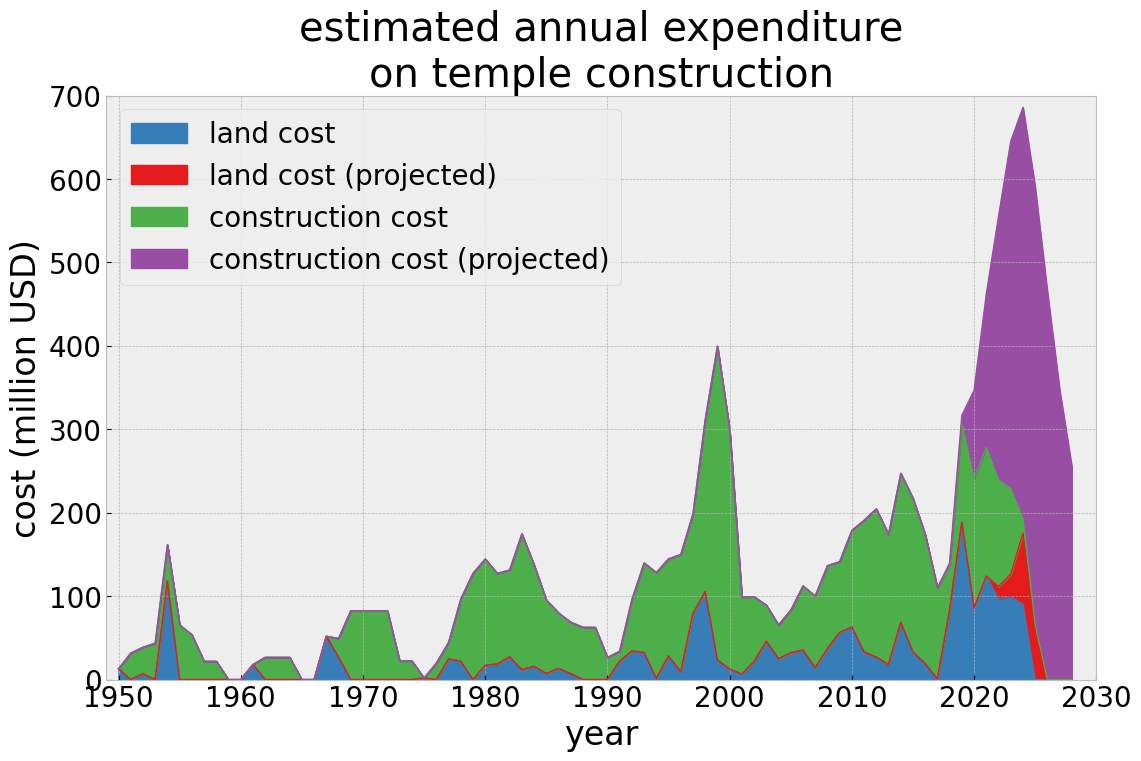

In [7]:
# stacked area graph of the 4 components of the total
ax = (yearly_total[['land cost', 'land cost (projected)',
                    'construction cost', 'construction cost (projected)']]/1e6).plot.area(
    title='estimated annual expenditure\non temple construction',
    stacked=True,
    ylabel='cost (million USD)',
    xlabel='year',
    xlim=[1949, 2030],
    ylim=[0, 700], lw=1)

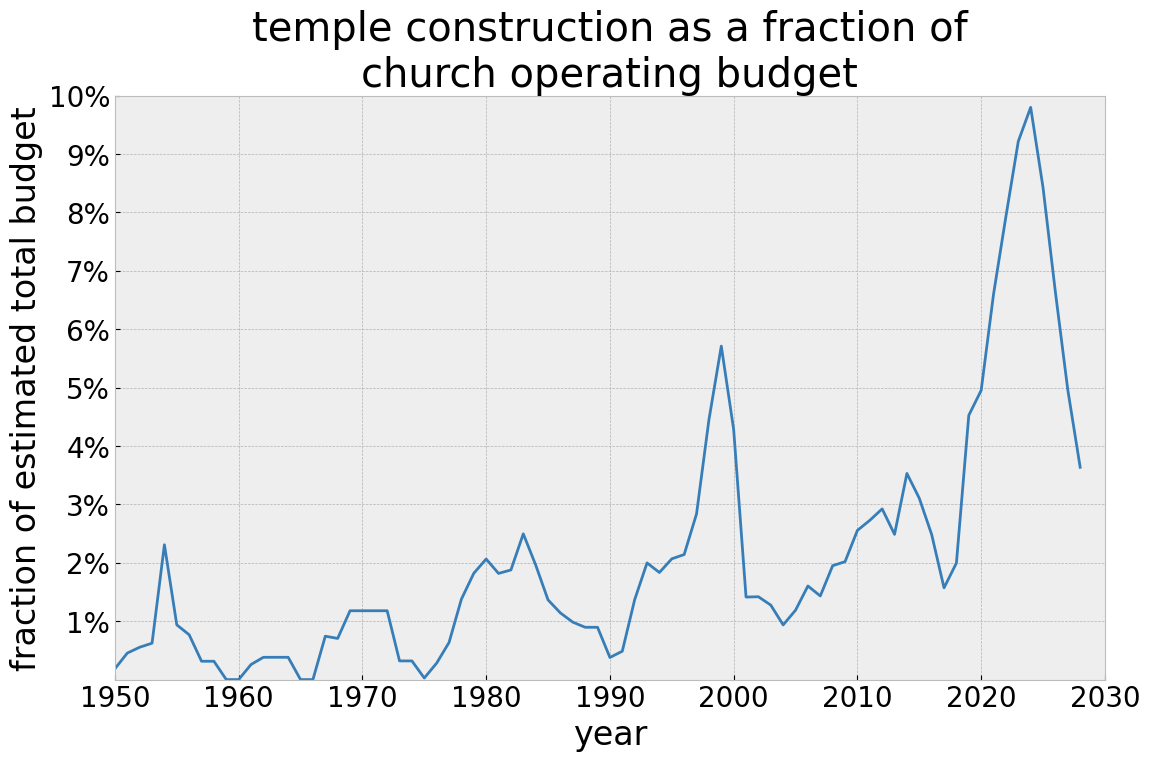

In [8]:
(yearly_total['total cost']/7e9*100).plot(
    title='temple construction as a fraction of\nchurch operating budget',
    xlabel='year',
    ylabel='fraction of estimated total budget',
    ylim=[0, 10],
    xlim=[1950, 2030])
yt = range(1, 11)
_ = pl.yticks(yt, [str(x)+'%' for x in yt])

## Member/temple ratio
In the previous analysis, the ratio of members to temple space proved particularly revealing. Using the published area in square feet makes it possible to account for the significant variability in sizes of temples. Tracing that trend back to the first pioneer era temples in Utah in the late 1800s showed that historically, there was less than 1 member per square foot of temple for decades. During the post World War II era that began to increase significantly, during a period from roughly the mid 1950s to early 1980s in which most of the temples were converted to use the filmed endowment presentation, thus making more efficient use of the same amount of floor space in each temple. All of the construction since the 1980s, including two prior surges of construction under presidents Kimball and Hinckley, mostly served to maintain the existing level of about 2.5 members per square foot of temple.

The current surge in temple construction is taking us into new territory. In this recalculated analysis, the projection is that before the end of the 2020s there will likely be over 10.4 million square feet of temple space, which would likely mean only 1.75 members per square foot of temple, a level not seen since the late 1960s.

In [9]:
td_ = td[~td['area'].isna()]

In [10]:
area_time = td_[['Dedication date','area']].sort_values('Dedication date')
area_time['total area (million sq ft)'] = area_time['area'].cumsum()/1e6
area_time['number'] = area_time.reset_index().index+1

area_time['year'] = area_time['Dedication date'].dt.year
year_end_vals = area_time.groupby('year')[['total area (million sq ft)', 'number']].max()

ym_tmp = year_end_vals.merge(
    md, left_index=True, right_on='Year', how='outer').sort_values('Year')
ym_tmp['date'] = pd.to_datetime(ym_tmp['Year'].apply(lambda x: f'{x+1}-01-01'))
# worst case growth: 0
last_idx = ym_tmp['Membership'].idxmax()
last_mem_val = ym_tmp.loc[last_idx]['Membership']
ym_tmp.loc[last_idx:, 'Membership (min)'] = last_mem_val
# best case growth: last 20 years
ref_mem_vals = ym_tmp[ym_tmp['Year'].between(2000,2021)]['Membership']
growth_factor = np.mean(ref_mem_vals.values[1:]/ref_mem_vals.values[:-1])
proj_years = ym_tmp.loc[last_idx:]['Year']
proj_mem = (last_mem_val * growth_factor**(proj_years - proj_years.iloc[0])).round(0)
ym_tmp.loc[last_idx:, 'Membership (max)'] = proj_mem

ym = ym_tmp[ym_tmp['Year']>=1877].copy()
ym['area'] = ym['total area (million sq ft)'].fillna(method='ffill')*1e6
ym['number'] = ym['number'].fillna(method='ffill').astype(int)

In [11]:
m_t = ym[['Membership', 'Membership (min)', 'Membership (max)']].divide(ym['number'], 0)
m_t.index = ym['date']
m_t.columns = ['historical', 'projected (min)', 'projected (max)']

m_a = ym[['Membership', 'Membership (min)', 'Membership (max)']].divide(ym['area'], 0)
m_a.index = ym['date']
m_a.columns = ['historical', 'projected (min)', 'projected (max)']

In [12]:
# calculate how many temples were using filmed endowment presentation
ef = td[['Name', 'Dedication date']].copy()
#ef['Dedication']<'1950-01-01'
film_era = ef['Dedication date']>'1950-01-01'
ef.loc[film_era, 'film_start'] = ef[film_era]['Dedication date']

conversion_dates = [
    ['St. George Utah Temple', '1975-11-11'],
    ['Logan Utah Temple', '1979-03-13'],
    ['Manti Utah Temple', '2025-01-01'],
    ['Salt Lake Temple', '2025-01-01'],
    ['Laie Hawaii Temple', '1978-06-13'],
    ['Cardston Alberta Temple', '1991-03-22'], # rededication date, seems later than the others
    ['Mesa Arizona Temple', '1975-04-16'],
    ['Idaho Falls Idaho Temple', '1975-01-01'] # no exact date on this one
]

for temple, date in conversion_dates:
    ef.loc[ef['Name']==temple, 'film_start'] = date
ef = ef.sort_values('Dedication date')
ef['total'] = np.arange(len(ef)) + 1
ef['film'] = 0
for idx, row in ef.iterrows():
    ef.loc[idx, 'film'] = (ef.loc[:idx, 'film_start']<=row['Dedication date']).sum()
ef['film_frac'] = ef['film']/ef['total']
#ef.plot(x='Dedication date', y='film_frac')

In [13]:
bg_shade = '#d7d7e7'
kimball_temples = ('1983-01-01', '1987-01-01')
hinckley_temples = ('1999-01-01', '2002-01-01')
nelson_temples = ('2022-01-01', '2029-07-01')
filmed_endowment_transition = (ef[ef['film_frac']<=0.15].iloc[-1]['Dedication date'],
                               ef[ef['film_frac']>=0.9].iloc[0]['Dedication date'])

def dateinterp(dates, r):
    a, b = [np.datetime64(val) for val in dates]
    return a + (b-a)*r

def add_bg(ax, bg='fkh', text=True, yvals={}):
    y_pos = lambda y: np.inner(ax.get_ylim(), (1-y, y))
    y_vals = {key:y_pos(0.05) for key in ('f', 'k', 'h', 'n')}
    y_vals.update(yvals)

    if 'f' in bg:
        ax.axvspan(*filmed_endowment_transition, color='#d7f7d7')
        if text:
            ax.annotate('transition to\nfilmed\nendowment', ('1958-01-01', y_vals['f']),
                        size='x-small', ha='left', va='bottom')
    if 'k' in bg:
        ax.axvspan(*kimball_temples, color=bg_shade)
        if text:
            ax.annotate('Kimball surge',
                        (dateinterp(kimball_temples, 0.7), y_vals['k']),
                        size='x-small', ha='center', va='bottom', rotation=90)
    if 'h' in bg:
        ax.axvspan(*hinckley_temples, color=bg_shade)
        if text:
            ax.annotate('Hinckley surge',
                        (dateinterp(hinckley_temples, 0.7), y_vals['h']),
                        size='x-small', ha='center', va='bottom', rotation=90)
    if 'n' in bg:
        ax.axvspan(*nelson_temples, color=bg_shade, zorder=0)
        if text:
            ax.annotate('Nelson surge',
                        (dateinterp(nelson_temples, 0.7), y_vals['n']),
                        size='x-small', ha='right', va='bottom', rotation=90)

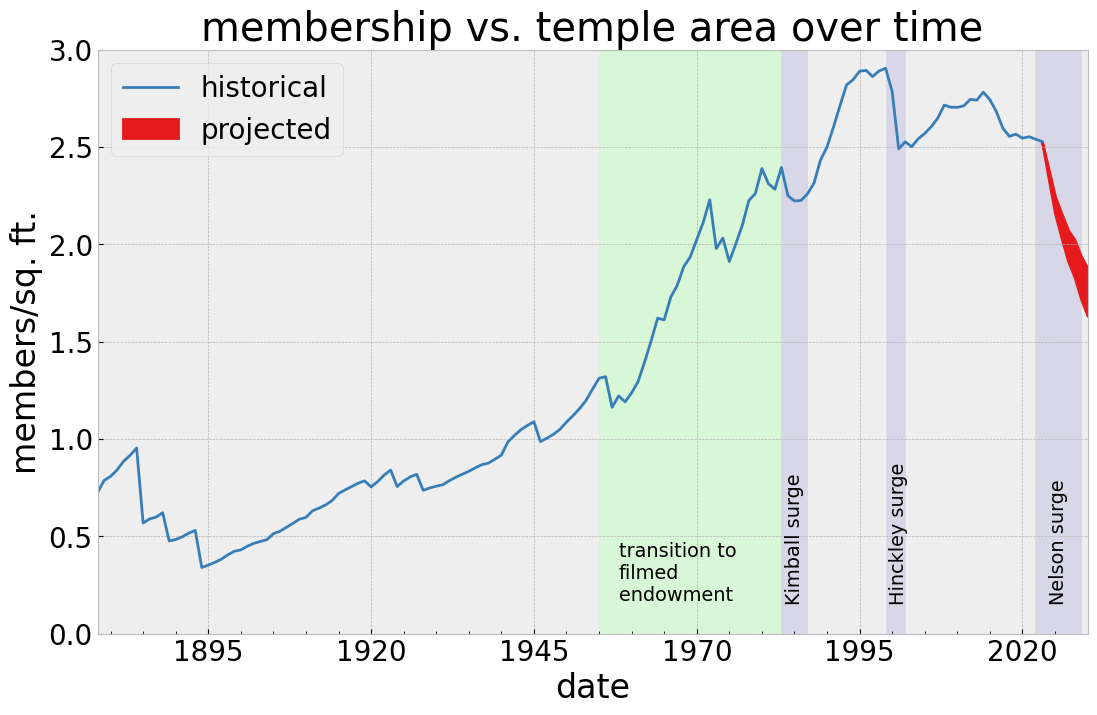

In [14]:
lw_default=2
#ax1 = m_t['historical'].plot(ylim=[0, None])
#ax1.fill_between(m_t.index, m_t['projected (min)'], m_t['projected (max)'],
#                 color=clist[1], lw=lw_default)
#ax1.legend(['historical', 'projected'], loc='upper left')
#add_bg(ax1, 'fkhn', yval=0.65)

pl.figure()
ax2 = m_a['historical'].plot(ylabel='members/sq. ft.', ylim=[0, 3],
                            title='membership vs. temple area over time')
ax2.fill_between(m_a.index, m_a['projected (min)'], m_a['projected (max)'],
                 color=clist[1], lw=lw_default)
ax2.legend(['historical', 'projected'], loc='upper left')
add_bg(ax2, 'fkhn')

## Construction progress
The huge number of announced temples also raises questions about when they might realistically be completed. Since 2008, the average time to groundbreaking for completed temples is about 2 1/2 years, and average time to dedication around 6 years. As we are now approaching 6 years since the big increase in temple announcements began, we will not know for some time how well the temple construction program is keeping pace with announcements, but there are some hints in the data now that the average numbers are likely to increase in the coming years.

The chart below shows temple construction activity by year since 1995, split into announcements, groundbreakings, and dedications. The charts clearly show two peaks. The first is the brief Hinckley-era surge in construction. It consisted of a big number of announcements in 1998, a peak in groundbreaking the following year, and in dedications in 2000. The entire surge was completed fairly quickly. In the context of normal temple building at the time (about 2 completed per year), it was a remarkable achievement. It was likely made possible by in part by various factors, including the introduction of a much smaller design that was replicated on a large scale, and the fact that the goal was somewhat finite in scope.

The current surge in construction, by contrast, is very different, as it's no longer just a single group of new temples being announced in one year. The number of temples announced per year jumped from a historical average of 4-5 per year to a new normal of over 15 per year in 2018, and jumped again to an even higher new normal of over 30 per year in 2021-2023. We can see a corresponding uptick of groundbreakings beginning in 2020, and an increase in dedications in 2023, which is about a 5 year lag from the jump in announcements in 2018. There will likely be even more dedications next year, but there are reasons to believe the average time to completion may be headed upward, as the number of groundbreakings in 2023 declined from 2022, 3 years after a big jump in announcements. There are complicating factors at work, such as the pandemic.

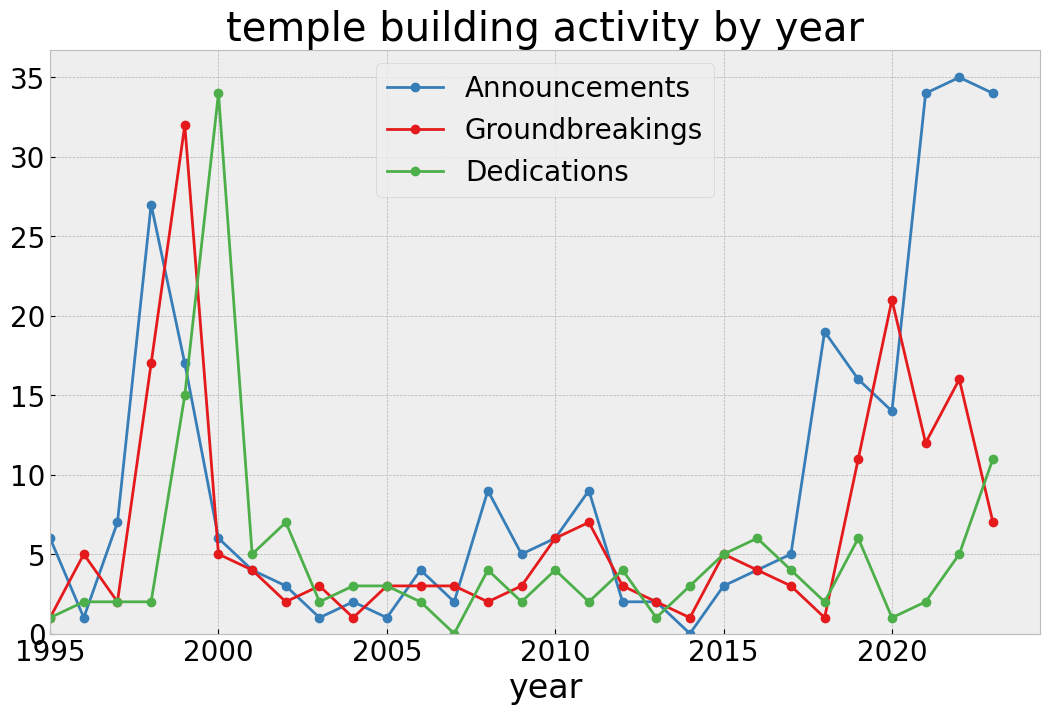

In [15]:
date_cols = ['Announcement date', 'Groundbreaking date', 'Dedication date']
activity_year = pd.DataFrame()
backlog = pd.DataFrame()
for yr in range(1995, 2024):
    backlog.loc[yr, 'planning'] = ((td_raw['Announcement date'] <= f'{yr}-12-31') &
                                   ((td_raw['Groundbreaking date'] > f'{yr}-12-31') |
                                    (td_raw['Groundbreaking date'].isna()))).sum()
    backlog.loc[yr, 'construction'] = ((td_raw['Groundbreaking date'] <= f'{yr}-12-31') &
                                       ((td_raw['Dedication date'] > f'{yr}-12-31') |
                                        (td_raw['Dedication date'].isna()))).sum()
    for c in date_cols:
        activity_year.loc[yr, c[:-5]+'s'] = (td_raw[c].dt.year==yr).sum()
backlog['total'] = backlog.sum(axis=1)

_ = activity_year.plot(xlim=[1995, None], ylim=[0, None], xlabel='year', marker='o',
                   title='temple building activity by year')

Another measure of the progress of the construction program is to measure the backlog. The plot below shows the backlog levels going back to 1995. The "planning" backlog is defined by the number of temples announced for which a groundbreaking has not taken place at the end of that calendar year. The "construction" backlog is the number for which groundbreaking has taken place but dedication has not.

The original peak in temples in construction phase was in 1999 at just over 40. In recent years the construction backlog has increased to between 50 and 60, and seems to be holding steady at that level. The total backlog, now over 150, is about 3 times what it was in 1999. Much of that backlog is now for temples in the planning phase. The leveling off of the construction backlog since 2021 is an possible indicator that the temple department has reached its maximum capacity given current available resources, and that ground is not being broken on new projects until old ones are completed. If this explanation is correct, we might expect that in the future actual construction time for new temples remains constant, but that the time to groundbreaking from announcement begins to grow significantly.

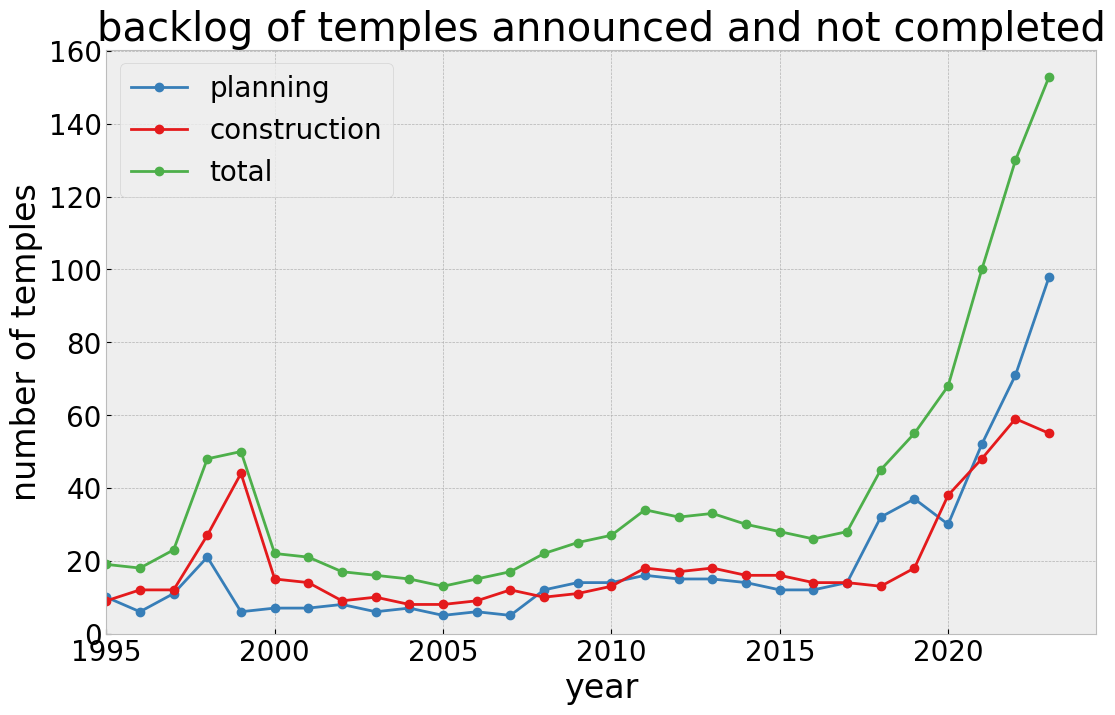

In [16]:
_ = backlog.plot(legend=True, marker='o',
                 ylim=[0, None], xlim=[1995, None],
                 xlabel='year', ylabel='number of temples',
                 title='backlog of temples announced and not completed')

In [17]:
const_time_data = td_raw[['Announcement date', 'Groundbreaking date', 'Dedication date']].copy()
const_time_data['time to groundbreaking'] = \
    (const_time_data['Groundbreaking date'] - const_time_data['Announcement date']).dt.days/365.25
const_time_data['time to dedication'] = \
    (const_time_data['Dedication date'] - const_time_data['Announcement date']).dt.days/365.25

const_time_by_year = const_time_data[['time to groundbreaking',
                                      'time to dedication']].groupby(const_time_data['Announcement date'].dt.year).mean()
#_ = const_time_by_year.plot(xlim=[1990, None], ylim=[0, 10],
#                        xlabel='year announced', ylabel='time (years)', ls=None, marker='o')

In [18]:
an_cmpl = td_raw['Announcement date'].dt.year.to_frame('year announced').assign(
    started=(~td_raw['Groundbreaking date'].isna()).astype(int).to_frame('started'),
    completed=(~td_raw['Dedication date'].isna()).astype(int).to_frame('completed'))

cmpl_frac = an_cmpl.groupby('year announced').mean()['completed']
last_cmpl = cmpl_frac[cmpl_frac==1].index[-1]

plotdata = an_cmpl.groupby('year announced').mean()
#ax = (plotdata[plotdata.index>=last_cmpl]*100).plot.bar(
#    title='progress of recently announced temples',
#    rot=0, width=0.7, ylabel='fraction completed (%)')

In [19]:
#total_area = td['area'].sum()
#total_area, total_area*2.5
## result: 10.4M sq ft, 26M members

In [20]:
# Setup show/hide source code box
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="show/hide source code"></form>''')